In [1]:
from fastai.basics import *

path = untar_data(URLs.MNIST_SAMPLE)

In [2]:
path.ls()

(#3) [Path('/home/jvinarek/.fastai/data/mnist_sample/valid'),Path('/home/jvinarek/.fastai/data/mnist_sample/train'),Path('/home/jvinarek/.fastai/data/mnist_sample/labels.csv')]

In [3]:
(path/'train').ls()

(#2) [Path('/home/jvinarek/.fastai/data/mnist_sample/train/3'),Path('/home/jvinarek/.fastai/data/mnist_sample/train/7')]

In [4]:
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()
threes

(#6131) [Path('/home/jvinarek/.fastai/data/mnist_sample/train/3/10.png'),Path('/home/jvinarek/.fastai/data/mnist_sample/train/3/10000.png'),Path('/home/jvinarek/.fastai/data/mnist_sample/train/3/10011.png'),Path('/home/jvinarek/.fastai/data/mnist_sample/train/3/10031.png'),Path('/home/jvinarek/.fastai/data/mnist_sample/train/3/10034.png'),Path('/home/jvinarek/.fastai/data/mnist_sample/train/3/10042.png'),Path('/home/jvinarek/.fastai/data/mnist_sample/train/3/10052.png'),Path('/home/jvinarek/.fastai/data/mnist_sample/train/3/1007.png'),Path('/home/jvinarek/.fastai/data/mnist_sample/train/3/10074.png'),Path('/home/jvinarek/.fastai/data/mnist_sample/train/3/10091.png')...]

In [5]:
from fastai.vision.all import *

im3_path = threes[1]
im3 = Image.open(im3_path)
im3

In [6]:
array(im3)[4:10, 4:10]

array([[  0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  29],
       [  0,   0,   0,  48, 166, 224],
       [  0,  93, 244, 249, 253, 187],
       [  0, 107, 253, 253, 230,  48],
       [  0,   3,  20,  20,  15,   0]], dtype=uint8)

In [7]:
tensor(im3)[4:10, 4:10]

tensor([[  0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,  29],
        [  0,   0,   0,  48, 166, 224],
        [  0,  93, 244, 249, 253, 187],
        [  0, 107, 253, 253, 230,  48],
        [  0,   3,  20,  20,  15,   0]], dtype=torch.uint8)

In [8]:
im3_t = tensor(im3)
df = pd.DataFrame(im3_t[4:30, 4:22])
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,29,150,195,254,255,254,176,193,150,96,0,0,0
2,0,0,0,48,166,224,253,253,234,196,253,253,253,253,233,0,0,0
3,0,93,244,249,253,187,46,10,8,4,10,194,253,253,233,0,0,0
4,0,107,253,253,230,48,0,0,0,0,0,192,253,253,156,0,0,0
5,0,3,20,20,15,0,0,0,0,0,43,224,253,245,74,0,0,0
6,0,0,0,0,0,0,0,0,0,0,249,253,245,126,0,0,0,0
7,0,0,0,0,0,0,0,14,101,223,253,248,124,0,0,0,0,0
8,0,0,0,0,0,11,166,239,253,253,253,187,30,0,0,0,0,0
9,0,0,0,0,0,16,248,250,253,253,253,253,232,213,111,2,0,0


## Baseline - pixel similarity

In [9]:
seven_tensors = [tensor(Image.open(o)) for o in sevens]
three_tensors = [tensor(Image.open(o)) for o in threes]
len(seven_tensors), len(three_tensors)

(6265, 6131)

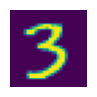

In [10]:
show_image(three_tensors[1]);

In [11]:
stacked_sevens = torch.stack(seven_tensors).float()/255
stacked_threes = torch.stack(three_tensors).float()/255
stacked_threes.shape

torch.Size([6131, 28, 28])

In [12]:
len(stacked_threes.shape)

3

In [13]:
stacked_threes.ndim

3

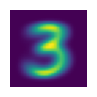

In [14]:
mean3 = stacked_threes.mean(0)
show_image(mean3);

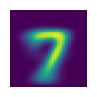

In [15]:
mean7 = stacked_sevens.mean(0)
show_image(mean7);

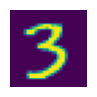

In [16]:
a_3 = stacked_threes[1]
show_image(a_3);

In [17]:
dist_3_abs = (a_3 - mean3).abs().mean()
dist_3_sqr = ((a_3 - mean3)**2).mean().sqrt()
dist_3_abs, dist_3_sqr

(tensor(0.1114), tensor(0.2021))

In [18]:
F.l1_loss(a_3.float(), mean7), F.mse_loss(a_3, mean7).sqrt()

(tensor(0.1586), tensor(0.3021))

In [19]:
valid_3_tens = torch.stack([tensor(Image.open(o)) for o in (path/'valid'/'3').ls()])
valid_3_tens = valid_3_tens.float()/255

valid_7_tens = torch.stack([tensor(Image.open(o)) for o in (path/'valid'/'7').ls()])
valid_7_tens = valid_7_tens.float()/255

valid_3_tens.shape, valid_7_tens.shape

(torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28]))

In [20]:
def mnist_distance(a, b):
    return (a - b).abs().mean((-1, -2))

mnist_distance(a_3, mean3)

tensor(0.1114)

In [21]:
valid_3_dist = mnist_distance(valid_3_tens, mean3)
valid_3_dist, valid_3_dist.shape

(tensor([0.1072, 0.1188, 0.1143,  ..., 0.1141, 0.1299, 0.1079]),
 torch.Size([1010]))

In [22]:
def is_3(x):
    return mnist_distance(x, mean3) < mnist_distance(x, mean7)

is_3(a_3), is_3(a_3).float()

(tensor(True), tensor(1.))

In [23]:
is_3(valid_3_tens)

tensor([True, True, True,  ..., True, True, True])

In [24]:
accuracy_3s = is_3(valid_3_tens).float().mean()
accuracy_7s = (1 - is_3(valid_7_tens).float()).mean()

accuracy_3s, accuracy_7s

(tensor(0.9168), tensor(0.9854))

## MNIST loss function

In [26]:
train_x = torch.cat([stacked_threes, stacked_sevens]).view(-1, 28*28)
train_y = tensor([1]*len(threes) + [0]*len(sevens)).unsqueeze(1)

train_x.shape, train_y.shape

(torch.Size([12396, 784]), torch.Size([12396, 1]))

In [27]:
dset = list(zip(train_x, train_y))
x, y = dset[0]
x.shape, y

(torch.Size([784]), tensor([1]))

In [28]:
valid_x = torch.cat([valid_3_tens, valid_7_tens]).view(-1, 28*28)
valid_y = tensor([1]*len(valid_3_tens) + [0]*len(valid_7_tens)).unsqueeze(1)
valid_dset = list(zip(valid_x, valid_y))

In [29]:
def init_params(size, std=1.0):
    return (torch.randn(size)*std).requires_grad_()

weights = init_params((28*28, 1))
weights.shape

torch.Size([784, 1])

In [30]:
bias = init_params(1)
bias

tensor([-0.2163], requires_grad=True)

In [31]:
(train_x[0] * weights.T).sum() + bias

tensor([5.3515], grad_fn=<AddBackward0>)

In [32]:
def linear1(xb):
    return xb@weights + bias

preds = linear1(train_x)
preds

tensor([[  5.3515],
        [ -1.6742],
        [-10.9377],
        ...,
        [ -9.9933],
        [ -4.0259],
        [ -6.0251]], grad_fn=<AddBackward0>)

In [33]:
corrects = (preds > 0.0).float() == train_y
corrects

tensor([[ True],
        [False],
        [False],
        ...,
        [ True],
        [ True],
        [ True]])

In [34]:
corrects.float().mean().item()

0.5892223119735718

In [35]:
# weights[0] *= 1.0001

# preds = linear1(train_x)
# ((preds > 0.0).float() == train_y).float().mean().item()

In [36]:
trgts = tensor([1, 0, 1])
prds = tensor([0.9, 0.4, 0.2])

torch.where(trgts==1, 1-prds, prds).mean()

tensor(0.4333)

In [37]:
def plot_function(f, title=None, min=-2.1, max=2.1, color='r', ylim=None):
    x = torch.linspace(min,max, 100)[:,None]
    if ylim: plt.ylim(ylim)
    plt.plot(x, f(x), color)
    if title is not None: plt.title(title)

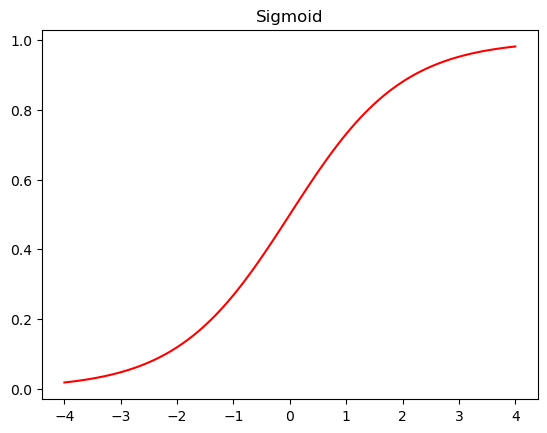

In [38]:
plot_function(torch.sigmoid, title='Sigmoid', min=-4, max=4)

In [39]:
def mnist_loss(predictions, targets):
    predictions = predictions.sigmoid()
    return torch.where(targets==1, 1-predictions, predictions).mean()

mnist_loss(prds, trgts)

tensor(0.4460)

## SGD and mini-batches

In [40]:
coll = range(15)
dl = DataLoader(coll, batch_size=5, shuffle=True)
list(dl)

[tensor([ 1, 10, 12,  5,  8]),
 tensor([ 7,  4, 11,  3,  2]),
 tensor([ 6,  9,  0, 13, 14])]

In [41]:
list(enumerate([10, 20, 30]))

[(0, 10), (1, 20), (2, 30)]

In [42]:
ds = L(enumerate(string.ascii_lowercase))
ds

(#26) [(0, 'a'),(1, 'b'),(2, 'c'),(3, 'd'),(4, 'e'),(5, 'f'),(6, 'g'),(7, 'h'),(8, 'i'),(9, 'j')...]

In [43]:
dl = DataLoader(ds, batch_size=6, shuffle=True)
list(dl)

[(tensor([22, 15, 11,  1, 17, 16]), ('w', 'p', 'l', 'b', 'r', 'q')),
 (tensor([ 8, 14, 23, 13, 20,  2]), ('i', 'o', 'x', 'n', 'u', 'c')),
 (tensor([ 3, 25,  7, 21, 24,  4]), ('d', 'z', 'h', 'v', 'y', 'e')),
 (tensor([10, 12,  0,  9, 18,  5]), ('k', 'm', 'a', 'j', 's', 'f')),
 (tensor([ 6, 19]), ('g', 't'))]

## Putting it all together

In [44]:
weights = init_params((28*28, 1))
bias = init_params(1)

weights.shape, bias

(torch.Size([784, 1]), tensor([0.4890], requires_grad=True))

In [45]:
dl = DataLoader(dset, batch_size=256)
xb, yb = first(dl)
xb.shape, yb.shape

(torch.Size([256, 784]), torch.Size([256, 1]))

In [46]:
??first

In [47]:
valid_dl = DataLoader(valid_dset, batch_size=256)

In [48]:
batch = train_x[:4]
batch.shape

torch.Size([4, 784])

In [49]:
preds = linear1(batch)
preds

tensor([[-5.6689],
        [-6.7713],
        [-6.9316],
        [-6.6990]], grad_fn=<AddBackward0>)

In [50]:
loss = mnist_loss(preds, train_y[:4])
loss

tensor(0.9983, grad_fn=<MeanBackward0>)

In [51]:
loss.backward()
weights.grad.shape, weights.grad.mean(), bias.grad

(torch.Size([784, 1]), tensor(-0.0003), tensor([-0.0017]))

In [52]:
def calc_grad(xb, yb, model):
    preds = model(xb)
    loss = mnist_loss(preds, yb)
    loss.backward()

In [53]:
calc_grad(batch, train_y[:4], linear1)
weights.grad.mean(), bias.grad

(tensor(-0.0005), tensor([-0.0034]))

In [54]:
calc_grad(batch, train_y[:4], linear1)
weights.grad.mean(), bias.grad

(tensor(-0.0008), tensor([-0.0051]))

In [55]:
weights.grad.zero_()
bias.grad.zero_();

In [56]:
def train_epoch(model, lr, params):
    for xb, yb in dl:
        calc_grad(xb, yb, model)
        for p in params:
            p.data -= p.grad*lr
            p.grad.zero_()

In [57]:
(preds>0.0).float() == train_y[:4]

tensor([[False],
        [False],
        [False],
        [False]])

In [58]:
def batch_accuracy(xb, yb):
    preds = xb.sigmoid()
    correct = (preds>0.5) == yb
    return correct.float().mean()

In [59]:
batch_accuracy(linear1(batch), train_y[:4])

tensor(0.)

In [64]:
def validate_epoch(model):
    accs = [batch_accuracy(model(xb), yb) for xb, yb in valid_dl]
    return round(torch.stack(accs).mean().item(), 4)

validate_epoch(linear1)

0.4849

In [66]:
lr = 1.
params = weights,bias
train_epoch(linear1, lr, params)
validate_epoch(linear1)

0.6274

In [67]:
for i in range(20):
    train_epoch(linear1, lr, params)
    print(validate_epoch(linear1), end= ' ')

0.8447 0.9135 0.9355 0.9482 0.955 0.9579 0.9603 0.9618 0.9638 0.9667 0.9682 0.9687 0.9696 0.9706 0.9716 0.9716 0.9726 0.9735 0.974 0.9745 

## Creating an Optimizer

In [68]:
linear_model = nn.Linear(28*28, 1)

w,b = linear_model.parameters()
w.shape, b.shape

(torch.Size([1, 784]), torch.Size([1]))

In [69]:
class BasicOptim:
    def __init__(self, params, lr):
        self.params, self.lr = list(params), lr
    
    def step(self, *args, **kwargs):
        for p in self.params:
            p.data -= p.grad.data * self.lr
    
    def zero_grad(self, *args, **kwargs):
        for p in self.params:
            p.grad = None
            

opt = BasicOptim(linear_model.parameters(), lr)

def train_epoch(model):
    for xb, yb in dl:
        calc_grad(xb, yb, model)
        opt.step()
        opt.zero_grad()

In [70]:
validate_epoch(linear_model)

0.4213

In [71]:
def train_model(model, epochs):
    for i in range(epochs):
        train_epoch(model)
        print(validate_epoch(model), end=' ')

In [72]:
train_model(linear_model, 20)

0.4932 0.9466 0.7656 0.895 0.9267 0.9429 0.9536 0.9604 0.9653 0.9663 0.9687 0.9692 0.9731 0.9746 0.9755 0.9765 0.9775 0.978 0.9785 0.9785 

In [73]:
dls = DataLoaders(dl, valid_dl)

In [74]:
learn = Learner(dls, nn.Linear(28*28, 1), opt_func=SGD, loss_func=mnist_loss, metrics=batch_accuracy)

In [80]:
learn.fit(10, lr=lr)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.013063,0.022027,0.981845,00:00
1,0.013002,0.021831,0.981845,00:00
2,0.012934,0.021649,0.981354,00:00
3,0.012861,0.021478,0.980864,00:00
4,0.012786,0.021317,0.980864,00:00
5,0.012712,0.021167,0.981354,00:00
6,0.012638,0.021025,0.981354,00:00
7,0.012566,0.020891,0.981354,00:00
8,0.012496,0.020764,0.981354,00:00
9,0.012427,0.020643,0.981354,00:00


## Adding a Nonlinearity

In [88]:
def simple_net(xb):
    res = xb@w1 + b1
    res = res.max(tensor(0.0))
    res = res@w2 + b2
    return res

w1 = init_params((28*28, 30))
b1 = init_params(30)
w2 = init_params((30, 1))
b2 = init_params(1)

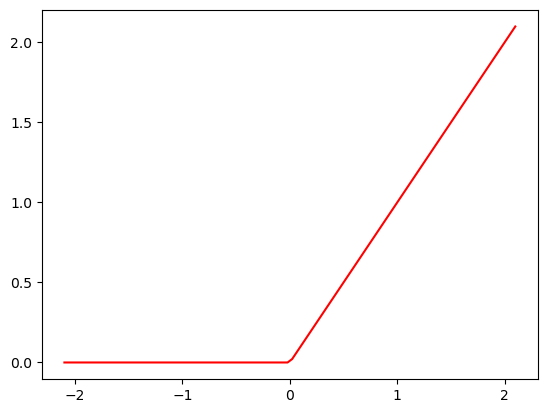

In [89]:
plot_function(F.relu)

In [90]:
simple_net = nn.Sequential(
    nn.Linear(28*28, 30),
    nn.ReLU(),
    nn.Linear(30, 1),
)

In [91]:
learn = Learner(dls, simple_net, opt_func=SGD, loss_func=mnist_loss, metrics=batch_accuracy)
learn.fit(40, 0.1)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.357114,0.391439,0.524534,00:00
1,0.161235,0.248457,0.777233,00:00
2,0.087146,0.122140,0.909715,00:00
3,0.055749,0.080945,0.938665,00:00
4,0.041398,0.062618,0.953386,00:00
5,0.034209,0.052454,0.965162,00:00
6,0.030170,0.046073,0.966143,00:00
7,0.027600,0.041721,0.967615,00:00
8,0.025776,0.038563,0.969578,00:00
9,0.024381,0.036152,0.970559,00:00


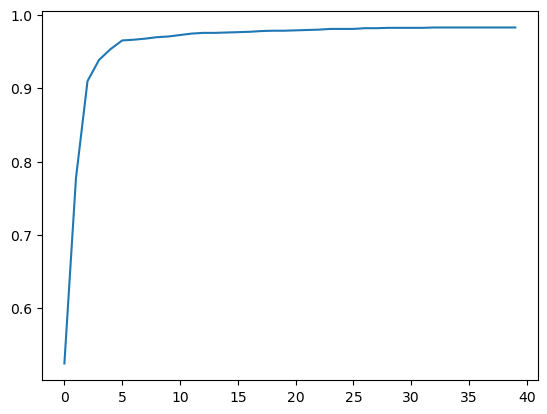

In [97]:
plt.plot(L(learn.recorder.values).itemgot(2))

In [98]:
learn.recorder.values[-1][2]

0.982826292514801

In [99]:
dls = ImageDataLoaders.from_folder(path)
learn = cnn_learner(dls, resnet18, pretrained=False, loss_func=F.cross_entropy, metrics=accuracy)
learn.fit_one_cycle(1, 0.1)

/home/jvinarek/mambaforge/lib/python3.10/site-packages/fastai/vision/learner.py:288: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
/home/jvinarek/mambaforge/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jvinarek/mambaforge/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


epoch,train_loss,valid_loss,accuracy,time
0,0.114088,0.013936,0.996565,01:24
